# Explore here

In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install xgboost
!pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.tools import add_constant 
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix


In [3]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv'
df = pd.read_csv(url)
pd.set_option('display.max_columns', None)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.shape

(1338, 7)

In [5]:
# Comprobamos duplicados
df.duplicated().sum()

np.int64(1)

In [6]:
#Eliminamos duplicados
df.drop_duplicates(inplace=True)

In [7]:
# Comprobamos si tenemos valores nulos
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
# Comprobamos si tenemos variables constantes
unicos = df.nunique()
unicos

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [10]:
# Factorizamos las variables categoricas

sex_mapped = {'male': 0, 'female': 1}
smoker_mapped = {'no': 0, 'yes': 1}
region_mapped = {'northwest': 0, 'southeast': 1, 'southwest': 2, 'northeast': 3}

df['sex'] = df['sex'].map(sex_mapped)  
df['smoker'] = df['smoker'].map(smoker_mapped)
df['region'] = df['region'].map(region_mapped)

<Axes: >

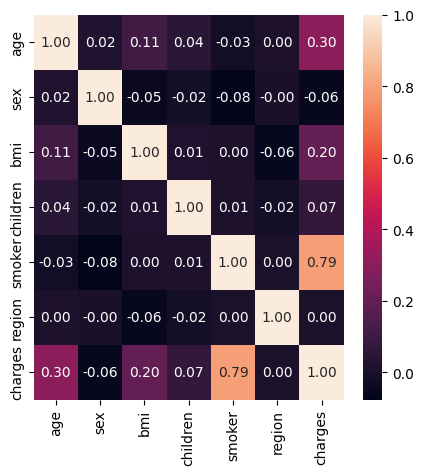

In [11]:
# Matriz de correlación 
fig, axes = plt.subplots(figsize =(5,5))
sns.heatmap (df[['age', 'sex','bmi','children', 'smoker', 'region','charges']].corr(), annot=True, fmt= '.2f')

De la gráfica anterior observamos lo siguiente con respecto a nuestro target:
- Existe una alta correlación positiva con la variable fumador. Si es fumador el cargo es más elevado.
- Existe correlación positiva no tan elevada con la variable edad. Cuanto más mayor, más alto es el cargo
- Existe correlación positiva con el índice masa muscular. A mayor bmi, más alto es el cargo

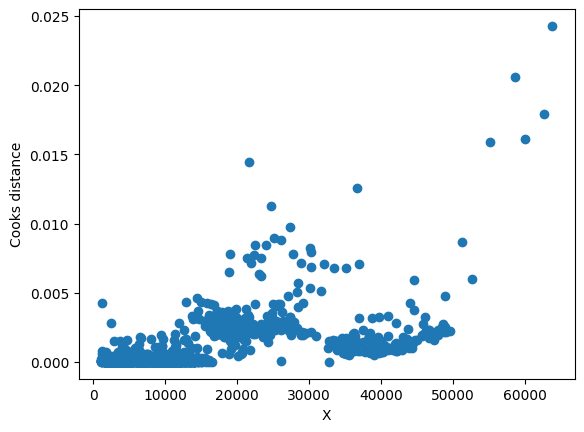

In [12]:
# Identificamos observaciones influyentes

X = df.drop(['charges'], axis =1)
y = df['charges']
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
cooks_distance = model.get_influence().cooks_distance

plt.scatter(df['charges'], cooks_distance[0])
plt.xlabel('X')
plt.ylabel('Cooks distance')
plt.show()

In [13]:
# Punto de corte para la distancia de cook
pto_corte =4/len(df)

#Observacines por encima del punto de corte
len(np.where(cooks_distance[0]>pto_corte)[0])

97

In [14]:
# Eliminamos las posiciones que se consideran influyentes
df_noinflu = df.drop(np.where(cooks_distance[0]>pto_corte)[0])

In [15]:
df_noinflu.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.90,0,1,2,16884.9240
1,18,0,33.77,1,0,1,1725.5523
2,28,0,33.00,3,0,1,4449.4620
4,32,0,28.88,0,0,0,3866.8552
5,31,1,25.74,0,0,1,3756.6216


In [16]:
# Escalamos las variables en 
#total_variables = ['age','sex','bmi','children', 'smoker', 'region', 'charges']
                   
#scaler = MinMaxScaler()
#var_total_scal = scaler.fit_transform(df_noinflu[total_variables])
#df_escalado = pd.DataFrame(var_total_scal,index =df_noinflu.index,columns = total_variables)
#df_escalado.head()

In [17]:
# Partición de los datos
X = df_noinflu.drop(['charges'], axis=1)
y = df_noinflu['charges']

# Separamos los datos en entrenamiento y testeo

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [18]:
# Selección de características, utilizamos XGBoost

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)
df_imp= pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100})
df_imp = df_imp.sort_values(by='Importance', ascending=False)
df_imp

,Feature,Importance
4,smoker,95.520988
2,bmi,1.718707
0,age,1.319406
3,children,0.567940
5,region,0.464795
1,sex,0.408163


In [19]:
# Seleccionamos las características que tienen una impportancia > 1%
X_train_imp = X_train[df_imp[df_imp.Importance>1]['Feature'].values]
X_test_imp = X_test[df_imp[df_imp.Importance>1]['Feature'].values]

In [20]:
# VIF
X_train_imp.corr()

,smoker,bmi,age
smoker,1.000000,0.019679,-0.015813
bmi,0.019679,1.000000,0.110495
age,-0.015813,0.110495,1.000000


In [21]:
# Escalado de variables
# Identificar las variables binarias
binary_cols = X_train_imp[(X_train_imp == 0)|(X_train_imp == 1)].dropna(axis=1).columns
binary_cols

Index(['smoker'], dtype='object')

In [22]:
# Seleccionamos las columnas que no son binarias
X_train_nobi = X_train_imp.drop(binary_cols, axis=1)
X_test_nobi= X_test_imp.drop(binary_cols, axis=1)

#Instanciamos al escalador y lo ajustamos con los datos de entrenamient
scaler = MinMaxScaler().fit(X_train_nobi)

In [23]:
# Trasnformamos los datos con el escalador ajustado
X_train_nobi_escal = scaler.transform(X_train_nobi)
X_test_nobi_escal = scaler.transform(X_test_nobi)

In [27]:
# Pasamos las variables X no binarias a dataframe y unimos las columnas binarias con las no binarias
X_train_nobi_escal = pd.DataFrame(X_train_nobi_escal, index=X_train_nobi.index, columns=X_train_nobi.columns)
X_test_nobi_escal = pd.DataFrame(X_test_nobi_escal, index=X_test_nobi.index, columns=X_test_nobi.columns)

X_train_bin = X_train[binary_cols].loc[X_train_nobi_escal.index]
X_test_bin = X_test[binary_cols].loc[X_test_nobi_escal.index]

bmi    0
age    0
dtype: int64

In [29]:
X_train_bin = X_train[binary_cols].loc[X_train_nobi_escal.index]
X_test_bin = X_test[binary_cols].loc[X_test_nobi_escal.index]

X_train_escal = pd.concat([X_train_nobi_escal, X_train[binary_cols]], axis=1)
X_test_escal = pd.concat([X_test_nobi_escal, X_test[binary_cols]], axis=1)

X_train_escal

,bmi,age,smoker
984,0.371872,0.043478,0
746,0.284776,0.347826,0
570,0.343492,0.282609,0
442,0.732420,0.000000,0
576,0.280302,0.086957,0
...,...,...,...
1125,0.231092,0.978261,0
1182,0.377045,0.152174,0
1219,0.374528,0.434783,0
922,0.396617,0.434783,0


In [30]:
# Creamos el modelo de regresión líneal y lo ajustamos a los datos
X_train_escal = sm.add_constant(X_train_escal)
X_test_escal = sm.add_constant(X_test_escal)

model = sm.OLS(y_train, X_train_escal)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     1269.
Date:                Thu, 06 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:00:04   Log-Likelihood:                -9931.1
No. Observations:                 992   AIC:                         1.987e+04
Df Residuals:                     988   BIC:                         1.989e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1533.4813    492.544     -3.113      0.0

Del resumen visto antes vemos lo siguiente:
- SI todas las variables son 0, el coste sería negativo
- Cada unidad que aumenta en el BMI aumenta charges en 10,56 unidades monetarias
- Cada año adicional de edad aumenta charges en 11,86 unidades monetarias
- Ser fumador incrementa el coste en 24,39€

In [35]:
# Probampos a pasar la target a escala logaritmica, dado que no tiene sentido que si todas las variables fueran 0 el coste fuera negativo

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

model_log = sm.OLS(y_train_log, X_train_escal).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     1144.
Date:                Thu, 06 Feb 2025   Prob (F-statistic):          7.05e-321
Time:                        21:08:21   Log-Likelihood:                -574.05
No. Observations:                 992   AIC:                             1156.
Df Residuals:                     988   BIC:                             1176.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8570      0.039    199.199      0.0

In [36]:
y_pred = results.predict(X_test_escal)
y_pred


448      7917.052160
279      8379.428831
357      9790.433408
670      5919.716310
111     11815.403354
            ...     
699      6388.598575
1054     2162.742639
192      2908.119527
33      13468.210371
561     12437.677254
Length: 248, dtype: float64

In [38]:
# Métricas de evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}") 
print(f"MSE: {mse}")   
print(f"R² Score: {r2}") 

MAE: 3779.3842851206587
MSE: 32558493.051759597
R² Score: 0.7910695688325973
